# `CNModel` Hyperfine Anomalies

Trey V. Wenger (c) December 2024

`CNModel` can also account for a full physical treatment of non-LTE effects. That is, it can model situations where the excitation temperature is *not* the same for each transition. `CNModel` considers the detailed balance between all transitions in the `mol_data` dictionary. For ${\rm CN}$ this includes all of the $N=1-0$ ($\nu = 0$) hyperfine transitions at 113.15 and 113.5 GHz, and for $^{13}{\rm CN}$ this includes all of the $N=1-0$ hyperfine transitions at 108.06 GHz, 108.4 GHz, 108.6 GHz, 108.8 GHz, and 109.2 GHz. Each state column density is a free parameter, and the relative state column densities are set by the excitation temperature. Since there are more transitions than states, this is an overconstrained problem and easy for a Bayesian forward model to solve.

In [1]:
# General imports    
import os
import pickle
import time

import matplotlib.pyplot as plt
import arviz as az
import pandas as pd
import numpy as np
import pymc as pm

print("pymc version:", pm.__version__)

import bayes_spec
print("bayes_spec version:", bayes_spec.__version__)

import bayes_cn_hfs
print("bayes_cn_hfs version:", bayes_cn_hfs.__version__)

# Notebook configuration
pd.options.display.max_rows = None

pymc version: 5.19.1
bayes_spec version: 1.7.2
bayes_cn_hfs version: 1.0.2+7.gdcf859e.dirty


## Simulate data

12CN-1 550
12CN-2 300

Tex
[[4.12856026 3.96747503 3.1873019 ]
 [4.5399173  4.04696193 3.20464574]
 [3.69857846 3.9586397  3.15530444]
 [4.0252573  4.03773639 3.17229877]
 [3.71034399 3.88448667 3.11707554]
 [4.45664982 4.00846584 3.18036483]
 [3.84982054 3.95676735 3.16007077]
 [4.03819297 3.96041608 3.13361988]
 [4.20388635 4.03555478 3.17706572]]

tau
[[0.03279808 0.04037087 0.06329175]
 [0.22725104 0.31871474 0.51230958]
 [0.27585192 0.3230911  0.50791146]
 [0.30592721 0.4046493  0.65221735]
 [0.35900344 0.42479004 0.66481766]
 [0.77590433 1.08261416 1.73688715]
 [0.2786214  0.33232113 0.52187335]
 [0.2363354  0.31592679 0.50679631]
 [0.02900114 0.03917752 0.06307717]]

tau_total
[2.52069396 3.28165564 5.22918177]

TR
[[1.99249393 1.85353569 1.20853435]
 [2.35363345 1.92161399 1.22200476]
 [1.62484414 1.84531682 1.18278676]
 [1.90225559 1.91300631 1.19591795]
 [1.63056562 1.77768066 1.14924015]
 [2.27468556 1.8836799  1.19882233]
 [1.74806458 1.8392205  1.18276265]
 [1.90900639 1.8

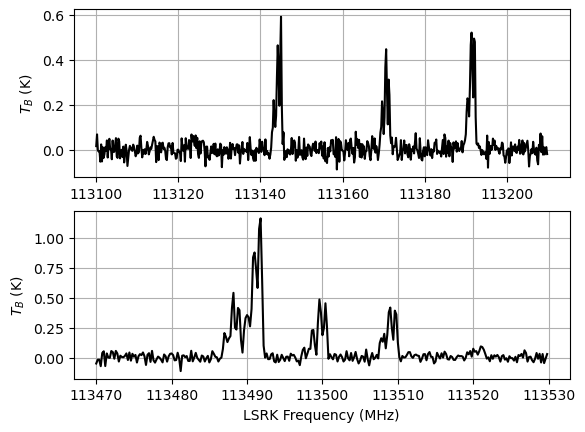

In [25]:
from bayes_cn_hfs import supplement_mol_data
from bayes_spec import SpecData
from bayes_cn_hfs.cn_model import CNModel

mol_data_12CN, mol_weight_12CN = supplement_mol_data("CN")

# spectral axis definition
freq_axis_1 = np.arange(113100.0, 113210.0, 0.2) # MHz
freq_axis_2 = np.arange(113470.0, 113530.0, 0.2) # MHz

# data noise can either be a scalar (assumed constant noise across the spectrum)
# or an array of the same length as the data
noise = 0.03 # K

# brightness data. In this case, we just throw in some random data for now
# since we are only doing this in order to simulate some actual data.
brightness_data_1 = noise * np.random.randn(len(freq_axis_1)) # K
brightness_data_2 = noise * np.random.randn(len(freq_axis_2)) # K

# CNModel datasets can be named anything, here we name them "12CN-1" and "12CN-2"
obs_1 = SpecData(
    freq_axis_1,
    brightness_data_1,
    noise,
    xlabel=r"LSRK Frequency (MHz)",
    ylabel=r"$T_B$ (K)",
)
obs_2 = SpecData(
    freq_axis_2,
    brightness_data_2,
    noise,
    xlabel=r"LSRK Frequency (MHz)",
    ylabel=r"$T_B$ (K)",
)
dummy_data = {"12CN-1": obs_1, "12CN-2": obs_2}
for label, dataset in dummy_data.items():
    print(label, len(dataset.spectral))
    # HACK: normalize data by noise
    dataset._brightness_offset = np.median(dataset.brightness)
    dataset._brightness_scale = dataset.noise

# Initialize and define the model
n_clouds = 3 # number of cloud components
baseline_degree = 0 # polynomial baseline degree
model = CNModel(
    dummy_data,
    molecule="CN", # molecule (either "CN" or "13CN")
    mol_data=mol_data_12CN, # molecular data
    bg_temp = 2.7, # assumed background temperature (K)
    Beff = 1.0, # beam efficiency
    Feff = 1.0, # forward efficiency
    n_clouds=n_clouds,
    baseline_degree=baseline_degree,
    seed=1234,
    verbose=True
)
model.add_priors(
    prior_log10_N = [13.75, 0.25], # mean and width of log10 total column density prior (cm-2)
    prior_log10_Tkin = [0.5, 0.1], # mean and width of log10 kinetic temperature prior (K)
    prior_velocity = [0.0, 3.0], # mean and width of velocity prior (km/s)
    prior_fwhm_nonthermal = 1.0, # width of non-thermal broadening prior (km/s)
    prior_fwhm_L = 1.0, # width of latent Lorentzian FWHM prior (km/s) TIP: set to typical feature separation
    prior_rms = None, # do not infer spectral rms
    prior_baseline_coeffs = None, # use default baseline priors
    assume_LTE = False, # do not assume LTE
    prior_log10_Tex = [0.5, 0.1], # mean and width of log10 excitation temperature prior (K)
    assume_CTEX = False, # do not assume CTEX
    prior_LTE_precision = 100.0, # width of LTE precision prior
    fix_log10_Tkin = None, # do not fix the kinetic temperature
    ordered = False, # do not assume optically-thin
)
model.add_likelihood()

sim_params = {
    "log10_N": [13.8, 13.9, 14.0],
    "log10_Tkin": [0.65, 0.6, 0.5],
    "fwhm_nonthermal": [1.0, 1.25, 1.5],
    "velocity": [-2.0, 0.0, 2.5],
    "fwhm_L": 0.0,
    "log10_Tex_ul": [0.65, 0.6, 0.5],
    "LTE_precision": [1.0e-3, 1.0e-4, 1.0e-5],
    "baseline_12CN-1_norm": [0.0],
    "baseline_12CN-2_norm": [0.0],
}
sim_obs1 = model.model["12CN-1"].eval(sim_params, on_unused_input="ignore")
sim_obs2 = model.model["12CN-2"].eval(sim_params, on_unused_input="ignore")

derived_params = ["Tex", "tau", "tau_total", "TR"]
derived_params = {
    param: model.model[param].eval(sim_params, on_unused_input="ignore")
    for param in derived_params
}

for key, value in derived_params.items():
    print()
    print(key)
    print(value)

# Plot the simulated data
fig, axes = plt.subplots(2)
axes[0].plot(dummy_data["12CN-1"].spectral, sim_obs1, "k-")
axes[0].set_ylabel(dummy_data["12CN-1"].ylabel)
axes[1].plot(dummy_data["12CN-2"].spectral, sim_obs2, "k-")
axes[1].set_xlabel(dummy_data["12CN-2"].xlabel)
_ = axes[1].set_ylabel(dummy_data["12CN-2"].ylabel)

## Model Definition

We fix the kinetic temperature because we can't measure the thermal line width.

In [26]:
# Now we pack the simulated spectrum into a new SpecData instance
obs_1 = SpecData(
    freq_axis_1,
    sim_obs1,
    noise,
    xlabel=r"LSRK Frequency (MHz)",
    ylabel=r"$T_B$ (K)",
)
obs_2 = SpecData(
    freq_axis_2,
    sim_obs2,
    noise,
    xlabel=r"LSRK Frequency (MHz)",
    ylabel=r"$T_B$ (K)",
)
data = {"12CN-1": obs_1, "12CN-2": obs_2}
for label, dataset in data.items():
    print(label, len(dataset.spectral))
    # HACK: normalize data by noise
    dataset._brightness_offset = np.median(dataset.brightness)
    dataset._brightness_scale = dataset.noise

# Initialize and define the model
model = CNModel(
    data,
    molecule="CN", # molecule (either "CN" or "13CN")
    mol_data=mol_data_12CN, # molecular data
    bg_temp = 2.7, # assumed background temperature (K)
    Beff = 1.0, # beam efficiency
    Feff = 1.0, # forward efficiency
    n_clouds=n_clouds,
    baseline_degree=baseline_degree,
    seed=1234,
    verbose=True
)
model.add_priors(
    prior_log10_N = [13.75, 0.25], # mean and width of log10 total column density prior (cm-2)
    prior_log10_Tkin = [0.5, 0.1], # mean and width of log10 kinetic temperature prior (K)
    prior_velocity = [0.0, 3.0], # mean and width of velocity prior (km/s)
    prior_fwhm_nonthermal = 1.0, # width of non-thermal broadening prior (km/s)
    prior_fwhm_L = 1.0, # width of latent Lorentzian FWHM prior (km/s) TIP: set to typical feature separation
    prior_rms = None, # do not infer spectral rms
    prior_baseline_coeffs = None, # use default baseline priors
    assume_LTE = False, # do not assume LTE
    prior_log10_Tex = [0.5, 0.1], # mean and width of log10 excitation temperature prior (K)
    assume_CTEX = False, # do not assume CTEX
    prior_LTE_precision = 100.0, # width of LTE precision prior
    fix_log10_Tkin = None, # do not fix the kinetic temperature
    ordered = False, # do not assume optically-thin
)
model.add_likelihood()

12CN-1 550
12CN-2 300


Sampling: [12CN-1, 12CN-2, LTE_precision, baseline_12CN-1_norm, baseline_12CN-2_norm, fwhm_L_norm, fwhm_nonthermal_norm, log10_N_norm, log10_Tex_ul_norm, log10_Tkin_norm, velocity_norm, weights]


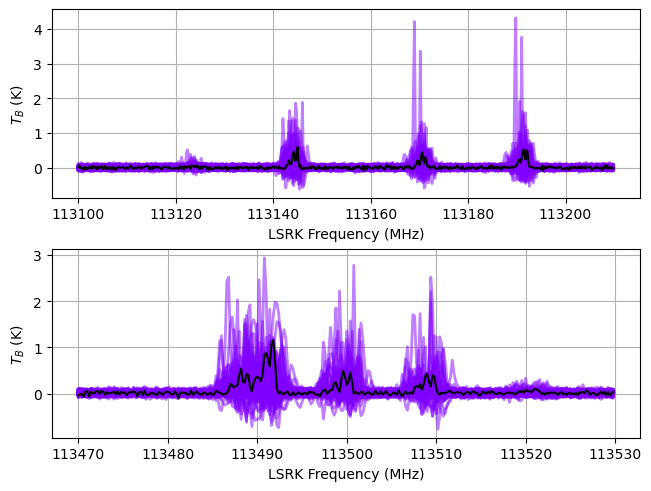

In [27]:
from bayes_spec.plots import plot_predictive

# prior predictive check
prior = model.sample_prior_predictive(
    samples=100,  # prior predictive samples
)
_ = plot_predictive(model.data, prior.prior_predictive)

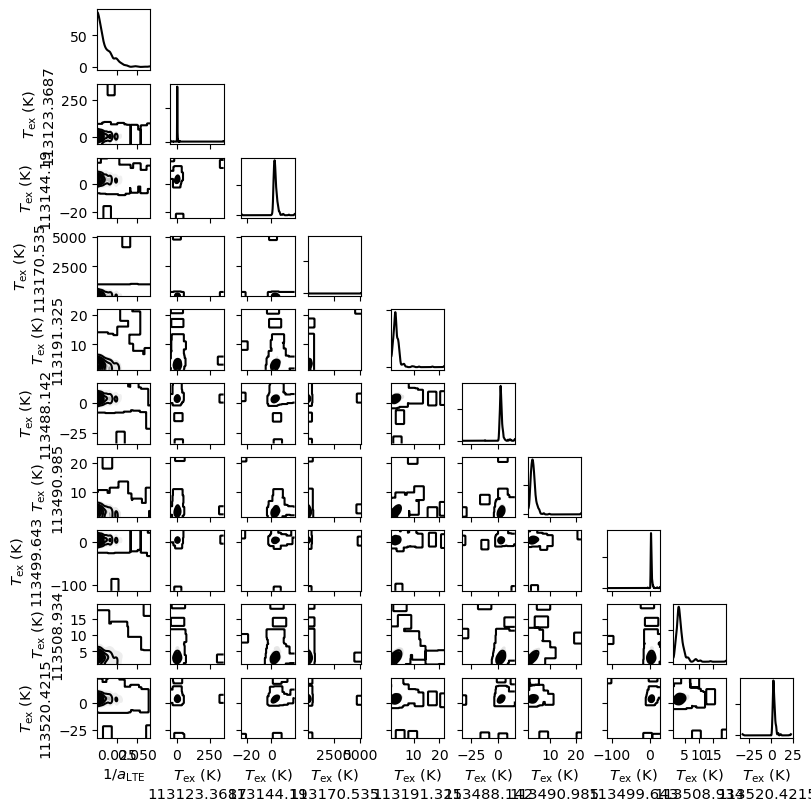

In [28]:
from bayes_spec.plots import plot_pair

axes = plot_pair(
    prior.prior, # samples
    ['LTE_precision', 'Tex'], # var_names to plot
    labeller=model.labeller, # label manager
)
axes.ravel()[0].figure.set_size_inches(8, 8)

## Variational Inference

In [29]:
start = time.time()
model.fit(
    n = 100_000, # maximum number of VI iterations
    draws = 1_000, # number of posterior samples
    rel_tolerance = 0.01, # VI relative convergence threshold
    abs_tolerance = 0.1, # VI absolute convergence threshold
    learning_rate = 0.01, # VI learning rate
)
end = time.time()
print(f"Runtime: {(end-start)/60.0:.2f} minutes")

Output()

Convergence achieved at 7800
Interrupted at 7,799 [7%]: Average Loss = 25,988


Output()

Runtime: 1.07 minutes


In [30]:
# ignore transition and state dependent parameters
var_names = [
    param for param in model.cloud_deterministics
    if not set(model.model.named_vars_to_dims[param]).intersection(set(["transition", "state"]))
]
pm.summary(model.trace.posterior, var_names=var_names + model.hyper_deterministics + model.baseline_freeRVs)

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
velocity[0]               2.514  0.041   2.446    2.599      0.001    0.001   
velocity[1]               0.008  0.014  -0.017    0.035      0.000    0.000   
velocity[2]              -2.001  0.011  -2.021   -1.979      0.000    0.000   
log10_Tkin[0]             0.507  0.103   0.310    0.710      0.003    0.002   
log10_Tkin[1]             0.492  0.111   0.282    0.700      0.003    0.002   
log10_Tkin[2]             0.499  0.113   0.293    0.707      0.004    0.003   
fwhm_thermal[0]           0.076  0.009   0.058    0.092      0.000    0.000   
fwhm_thermal[1]           0.075  0.010   0.056    0.092      0.000    0.000   
fwhm_thermal[2]           0.075  0.010   0.059    0.094      0.000    0.000   
fwhm_nonthermal[0]        1.676  0.082   1.523    1.824      0.003    0.002   
fwhm_nonthermal[1]        1.413  0.033   1.354    1.475      0.001    0.001   
fwhm_nonthermal[2]        1.066  0.031   1.014    1.128      0.001    0.001   
fwhm[0]                   1.677  0.082   1.525    1.826      0.003    0.002   
fwhm[1]                   1.415  0.033   1.356    1.477      0.001    0.001   
fwhm[2]                   1.069  0.031   1.016    1.131      0.001    0.001   
log10_N[0]               13.363  0.018  13.329   13.396      0.001    0.000   
log10_N[1]               13.482  0.007  13.468   13.495      0.000    0.000   
log10_N[2]               13.474  0.007  13.459   13.487      0.000    0.000   
log10_Tex_ul[0]           0.652  0.031   0.597    0.717      0.001    0.001   
log10_Tex_ul[1]           0.763  0.056   0.660    0.871      0.002    0.001   
log10_Tex_ul[2]           0.723  0.055   0.615    0.824      0.002    0.001   
tau_total[0]              0.825  0.039   0.754    0.901      0.001    0.001   
tau_total[1]              0.644  0.017   0.616    0.677      0.001    0.000   
tau_total[2]              0.766  0.019   0.732    0.799      0.001    0.000   
fwhm_L                    0.143  0.027   0.092    0.190      0.001    0.001   
baseline_12CN-1_norm[0]  -0.134  0.043  -0.212   -0.060      0.001    0.001   
baseline_12CN-2_norm[0]  -0.391  0.062  -0.515   -0.281      0.002    0.001   

                         ess_bulk  ess_tail  r_hat  
velocity[0]                 940.0     972.0    NaN  
velocity[1]                 970.0     944.0    NaN  
velocity[2]                1086.0     882.0    NaN  
log10_Tkin[0]               955.0     793.0    NaN  
log10_Tkin[1]              1009.0     881.0    NaN  
log10_Tkin[2]               905.0     907.0    NaN  
fwhm_thermal[0]             955.0     793.0    NaN  
fwhm_thermal[1]            1009.0     881.0    NaN  
fwhm_thermal[2]             905.0     907.0    NaN  
fwhm_nonthermal[0]          926.0     912.0    NaN  
fwhm_nonthermal[1]         1030.0    1062.0    NaN  
fwhm_nonthermal[2]          930.0    1015.0    NaN  
fwhm[0]                     924.0     912.0    NaN  
fwhm[1]                    1030.0    1062.0    NaN  
fwhm[2]                     930.0    1015.0    NaN  
log10_N[0]                 1098.0     862.0    NaN  
log10_N[1]                 1089.0     942.0    NaN  
log10_N[2]                  814.0     820.0    NaN  
log10_Tex_ul[0]             956.0     981.0    NaN  
log10_Tex_ul[1]             988.0     930.0    NaN  
log10_Tex_ul[2]             960.0     823.0    NaN  
tau_total[0]                982.0    1014.0    NaN  
tau_total[1]               1078.0     943.0    NaN  
tau_total[2]                817.0     892.0    NaN  
fwhm_L                      943.0     897.0    NaN  
baseline_12CN-1_norm[0]     932.0    1021.0    NaN  
baseline_12CN-2_norm[0]    1062.0    1024.0    NaN

Sampling: [12CN-1, 12CN-2]


Output()

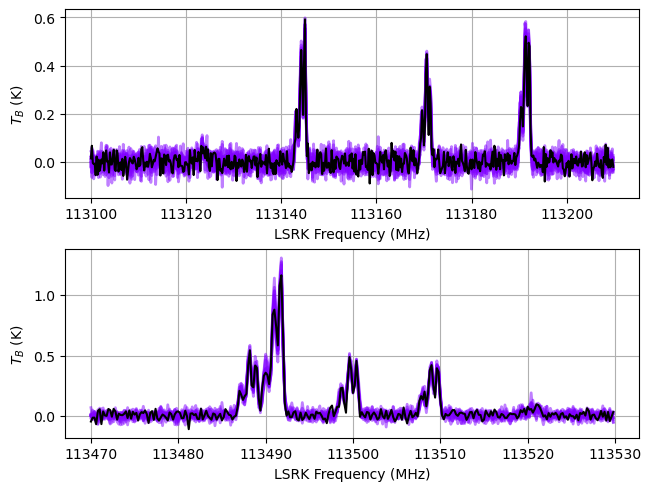

In [31]:
posterior = model.sample_posterior_predictive(
    thin=100, # keep one in {thin} posterior samples
)
_ = plot_predictive(model.data, posterior.posterior_predictive)

## MCMC

In [32]:
start = time.time()
model.sample(
    init = "advi+adapt_diag", # initialization strategy
    tune = 1000, # tuning samples
    draws = 1000, # posterior samples
    chains = 8, # number of independent chains
    cores = 8, # number of parallel chains
    init_kwargs = {"rel_tolerance": 0.01, "abs_tolerance": 0.1, "learning_rate": 0.01}, # VI initialization arguments
    nuts_kwargs = {"target_accept": 0.8}, # NUTS arguments
)
end = time.time()
print(f"Runtime: {(end-start)/60.0:.2f} minutes")

Initializing NUTS using custom advi+adapt_diag strategy


Output()

Convergence achieved at 7800
Interrupted at 7,799 [7%]: Average Loss = 25,988
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [baseline_12CN-1_norm, baseline_12CN-2_norm, velocity_norm, log10_Tkin_norm, fwhm_nonthermal_norm, fwhm_L_norm, log10_N_norm, log10_Tex_ul_norm, LTE_precision, weights]


Output()

Sampling 8 chains for 1_000 tune and 1_000 draw iterations (8_000 + 8_000 draws total) took 677 seconds.


Adding log-likelihood to trace


Output()

There were 595 divergences in converged chains.
Runtime: 12.76 minutes


In [35]:
model.solve(kl_div_threshold=0.1)

GMM converged to unique solution
7 of 8 chains appear converged.


Sampling: [12CN-1, 12CN-2]


Output()

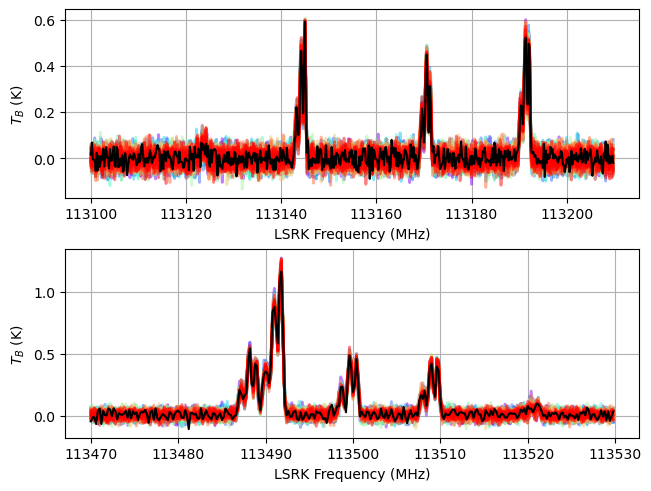

In [36]:
posterior = model.sample_posterior_predictive(
    thin=100, # keep one in {thin} posterior samples
)
_ = plot_predictive(model.data, posterior.posterior_predictive)

In [37]:
print("solutions:", model.solutions)

# ignore transition and state dependent parameters
var_names = [
    param for param in model.cloud_deterministics
    if not set(model.model.named_vars_to_dims[param]).intersection(set(["transition", "state"]))
] + ['Tex']
pm.summary(model.trace.solution_0, var_names=var_names + model.hyper_freeRVs + model.baseline_freeRVs)

solutions: [0]


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
velocity[0]               2.504  0.037   2.434    2.573      0.000    0.000   
velocity[1]              -0.004  0.016  -0.032    0.026      0.000    0.000   
velocity[2]              -1.999  0.012  -2.021   -1.974      0.000    0.000   
log10_Tkin[0]             0.502  0.099   0.307    0.683      0.001    0.001   
log10_Tkin[1]             0.503  0.101   0.302    0.682      0.001    0.001   
log10_Tkin[2]             0.500  0.100   0.323    0.698      0.001    0.001   
fwhm_thermal[0]           0.075  0.009   0.060    0.092      0.000    0.000   
fwhm_thermal[1]           0.075  0.009   0.059    0.092      0.000    0.000   
fwhm_thermal[2]           0.075  0.009   0.058    0.091      0.000    0.000   
fwhm_nonthermal[0]        1.556  0.119   1.331    1.775      0.003    0.002   
fwhm_nonthermal[1]        1.277  0.056   1.178    1.386      0.001    0.001   
fwhm_nonthermal[2]        0.926  0.056   0.819    1.030      0.001    0.001   
fwhm[0]                   1.558  0.119   1.334    1.776      0.003    0.002   
fwhm[1]                   1.279  0.056   1.180    1.388      0.001    0.001   
fwhm[2]                   0.929  0.056   0.822    1.032      0.001    0.001   
log10_N[0]               13.856  0.139  13.586   14.121      0.005    0.003   
log10_N[1]               13.904  0.057  13.808   14.028      0.003    0.002   
log10_N[2]               13.833  0.066  13.708   13.954      0.002    0.001   
log10_Tex_ul[0]           0.521  0.025   0.486    0.568      0.001    0.001   
log10_Tex_ul[1]           0.603  0.017   0.569    0.636      0.001    0.000   
log10_Tex_ul[2]           0.602  0.033   0.541    0.666      0.001    0.000   
tau_total[0]              3.817  1.308   1.222    6.148      0.039    0.028   
tau_total[1]              3.341  0.575   2.371    4.577      0.027    0.020   
tau_total[2]              2.823  0.539   1.872    3.877      0.014    0.010   
Tex[113123.3687, 0]       3.306  0.239   2.982    3.700      0.009    0.006   
Tex[113123.3687, 1]       3.997  0.193   3.606    4.316      0.008    0.006   
Tex[113123.3687, 2]       3.892  0.208   3.530    4.279      0.005    0.004   
Tex[113144.19, 0]         3.331  0.243   3.018    3.739      0.009    0.007   
Tex[113144.19, 1]         4.030  0.182   3.683    4.341      0.007    0.005   
Tex[113144.19, 2]         4.350  0.303   3.875    4.940      0.008    0.006   
Tex[113170.535, 0]        3.329  0.238   3.027    3.714      0.009    0.006   
Tex[113170.535, 1]        3.999  0.177   3.675    4.315      0.007    0.005   
Tex[113170.535, 2]        3.568  0.136   3.329    3.815      0.004    0.003   
Tex[113191.325, 0]        3.356  0.246   3.065    3.768      0.010    0.007   
Tex[113191.325, 1]        4.033  0.169   3.728    4.337      0.006    0.004   
Tex[113191.325, 2]        3.948  0.205   3.607    4.327      0.006    0.004   
Tex[113488.142, 0]        3.281  0.210   3.010    3.634      0.008    0.006   
Tex[113488.142, 1]        3.929  0.171   3.595    4.212      0.007    0.005   
Tex[113488.142, 2]        3.611  0.139   3.378    3.882      0.003    0.002   
Tex[113490.985, 0]        3.315  0.147   3.136    3.555      0.006    0.004   
Tex[113490.985, 1]        4.045  0.102   3.864    4.225      0.003    0.002   
Tex[113490.985, 2]        4.460  0.167   4.208    4.784      0.004    0.003   
Tex[113499.643, 0]        3.371  0.266   3.047    3.812      0.010    0.007   
Tex[113499.643, 1]        4.015  0.181   3.685    4.337      0.006    0.004   
Tex[113499.643, 2]        3.794  0.167   3.498    4.105      0.004    0.003   
Tex[113508.934, 0]        3.307  0.219   3.028    3.675      0.008    0.006   
Tex[113508.934, 1]        3.961  0.163   3.665    4.247      0.006    0.004   
Tex[113508.934, 2]        4.000  0.219   3.663    4.440      0.006    0.004   
Tex[113520.4215, 0]       3.399  0.286   3.073    3.882      0.011    0.008   
Tex[113520.4215, 1]       4.050  0.179   3.708    4.362      0.005    0.003  

['velocity_norm', 'log10_Tkin_norm', 'fwhm_nonthermal_norm', 'log10_N_norm', 'log10_Tex_ul_norm', 'LTE_precision', 'weights']


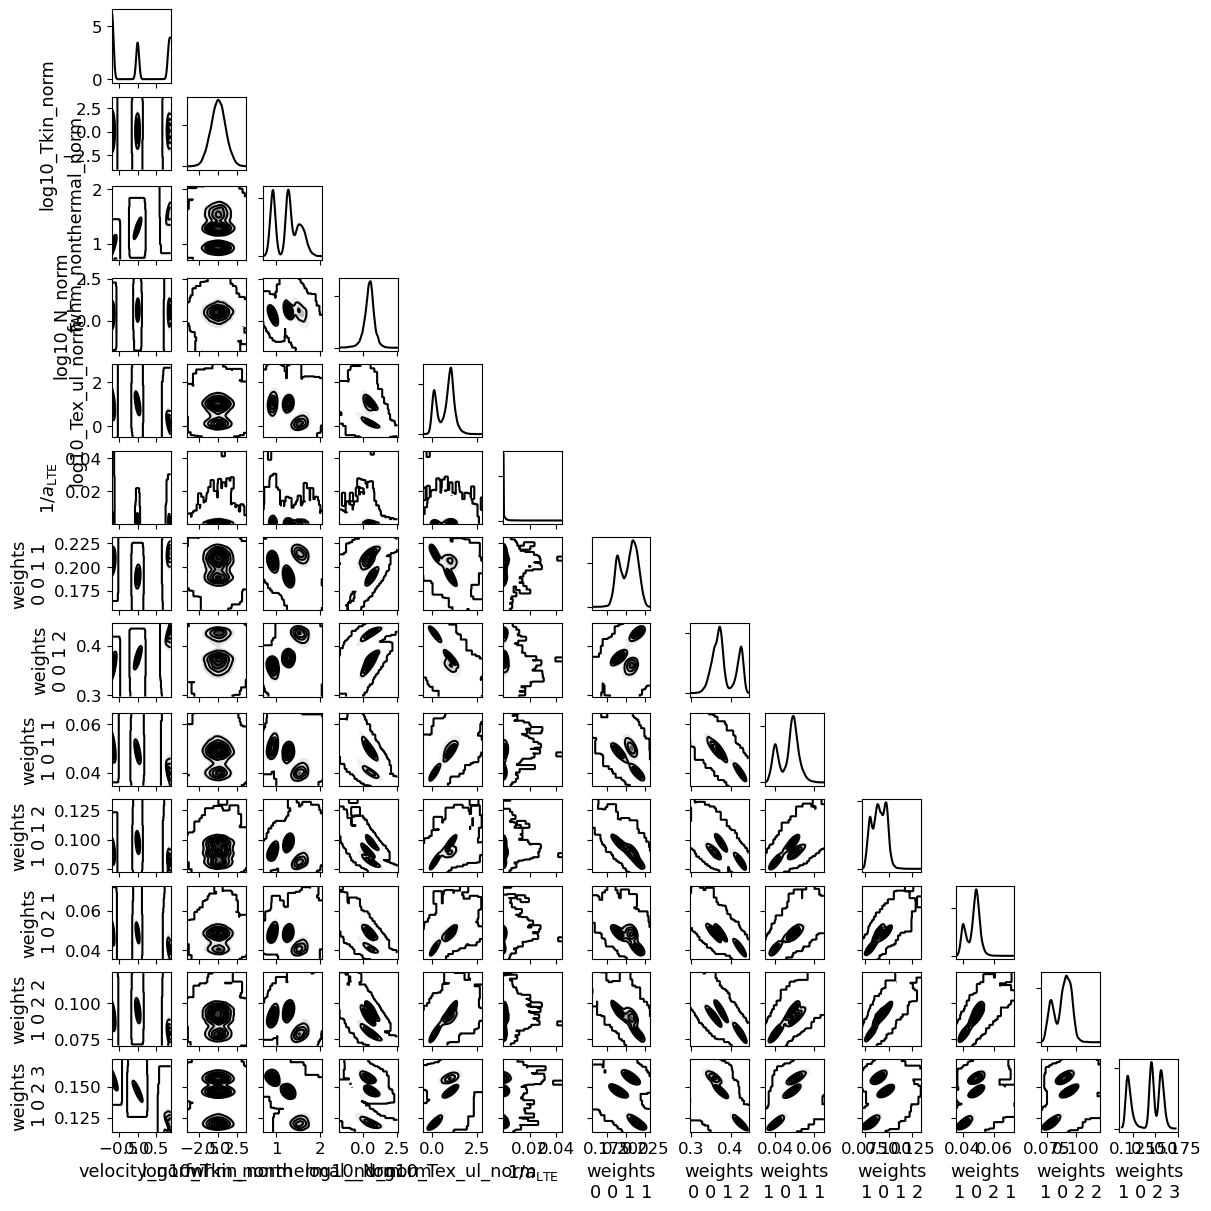

In [38]:
from bayes_spec.plots import plot_pair

var_names = [
    param for param in model.cloud_freeRVs
]
print(var_names)
axes = plot_pair(
    model.trace.solution_0, # samples
    var_names, # var_names to plot
    labeller=model.labeller, # label manager
)
_ = axes.ravel()[0].figure.set_size_inches(12, 12)

['velocity', 'log10_Tkin', 'fwhm_thermal', 'fwhm_nonthermal', 'fwhm', 'log10_N', 'log10_Tex_ul', 'tau_total']


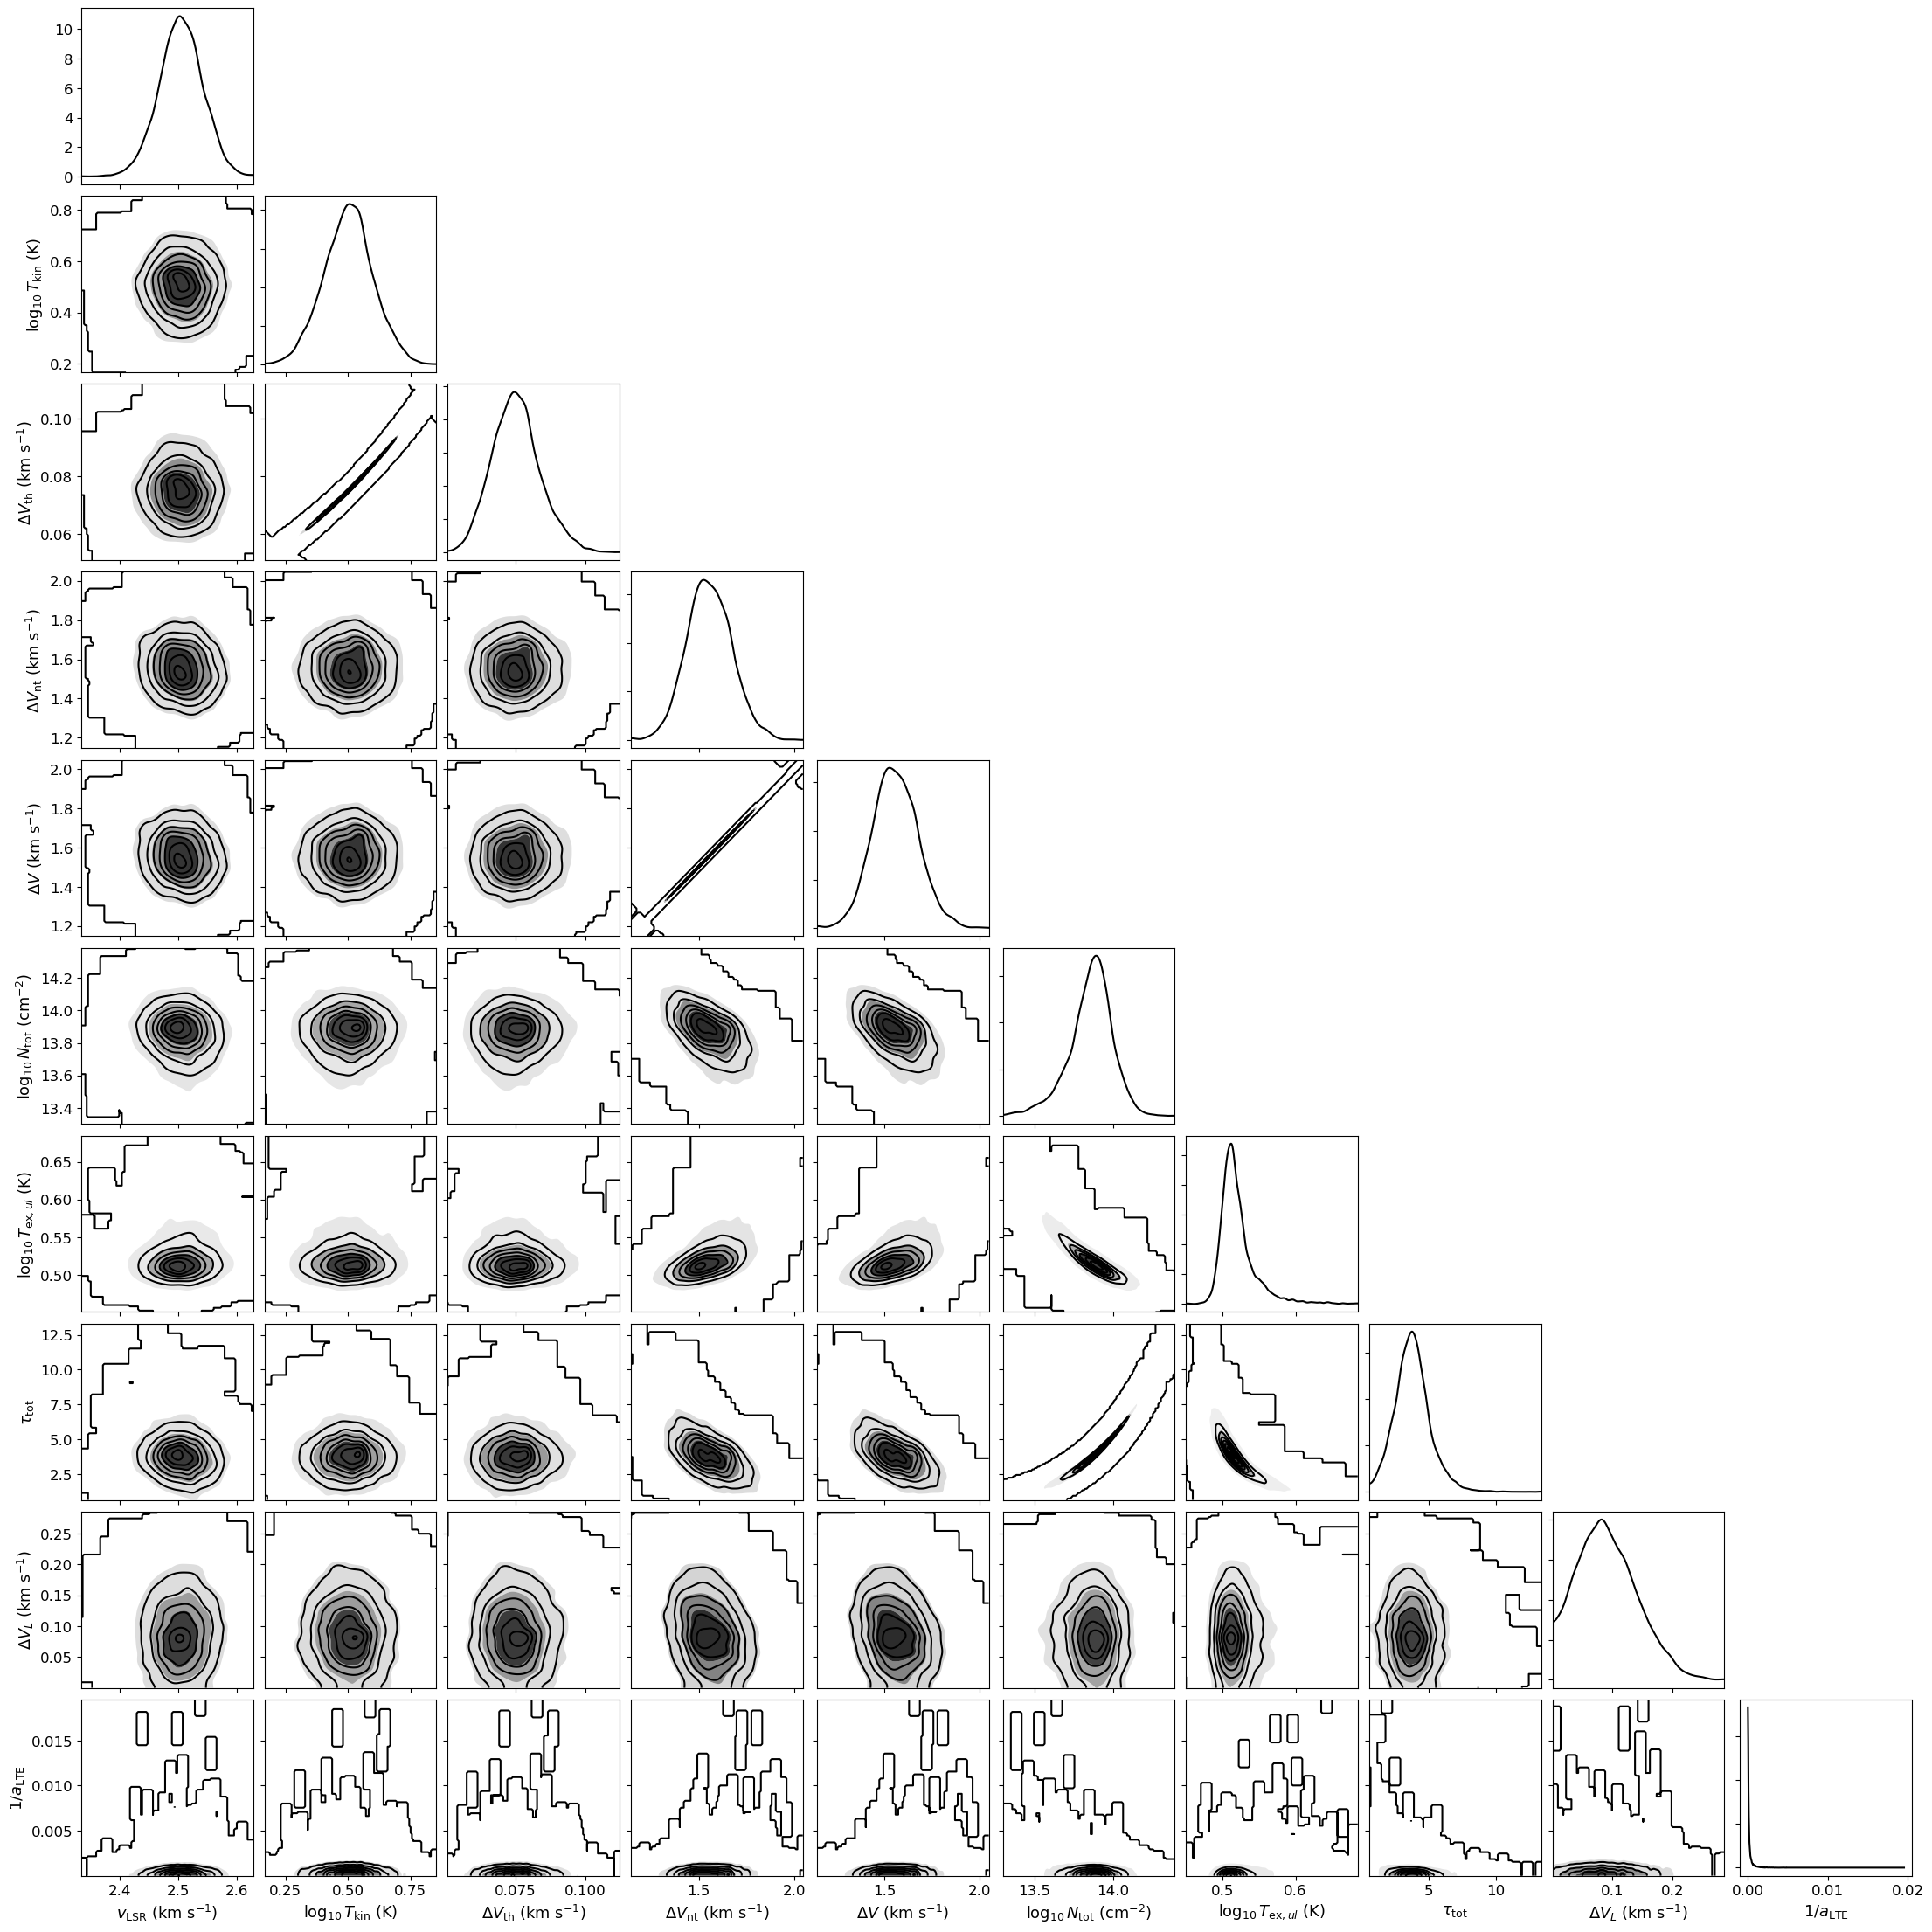

In [39]:
# ignore transition and state dependent parameters
var_names = [
    param for param in model.cloud_deterministics
    if not set(model.model.named_vars_to_dims[param]).intersection(set(["transition", "state"]))
]
print(var_names)
_ = plot_pair(
    model.trace.solution_0.sel(cloud=0), # samples
    var_names + model.hyper_deterministics + ["LTE_precision"], # var_names to plot
    labeller=model.labeller, # label manager
)

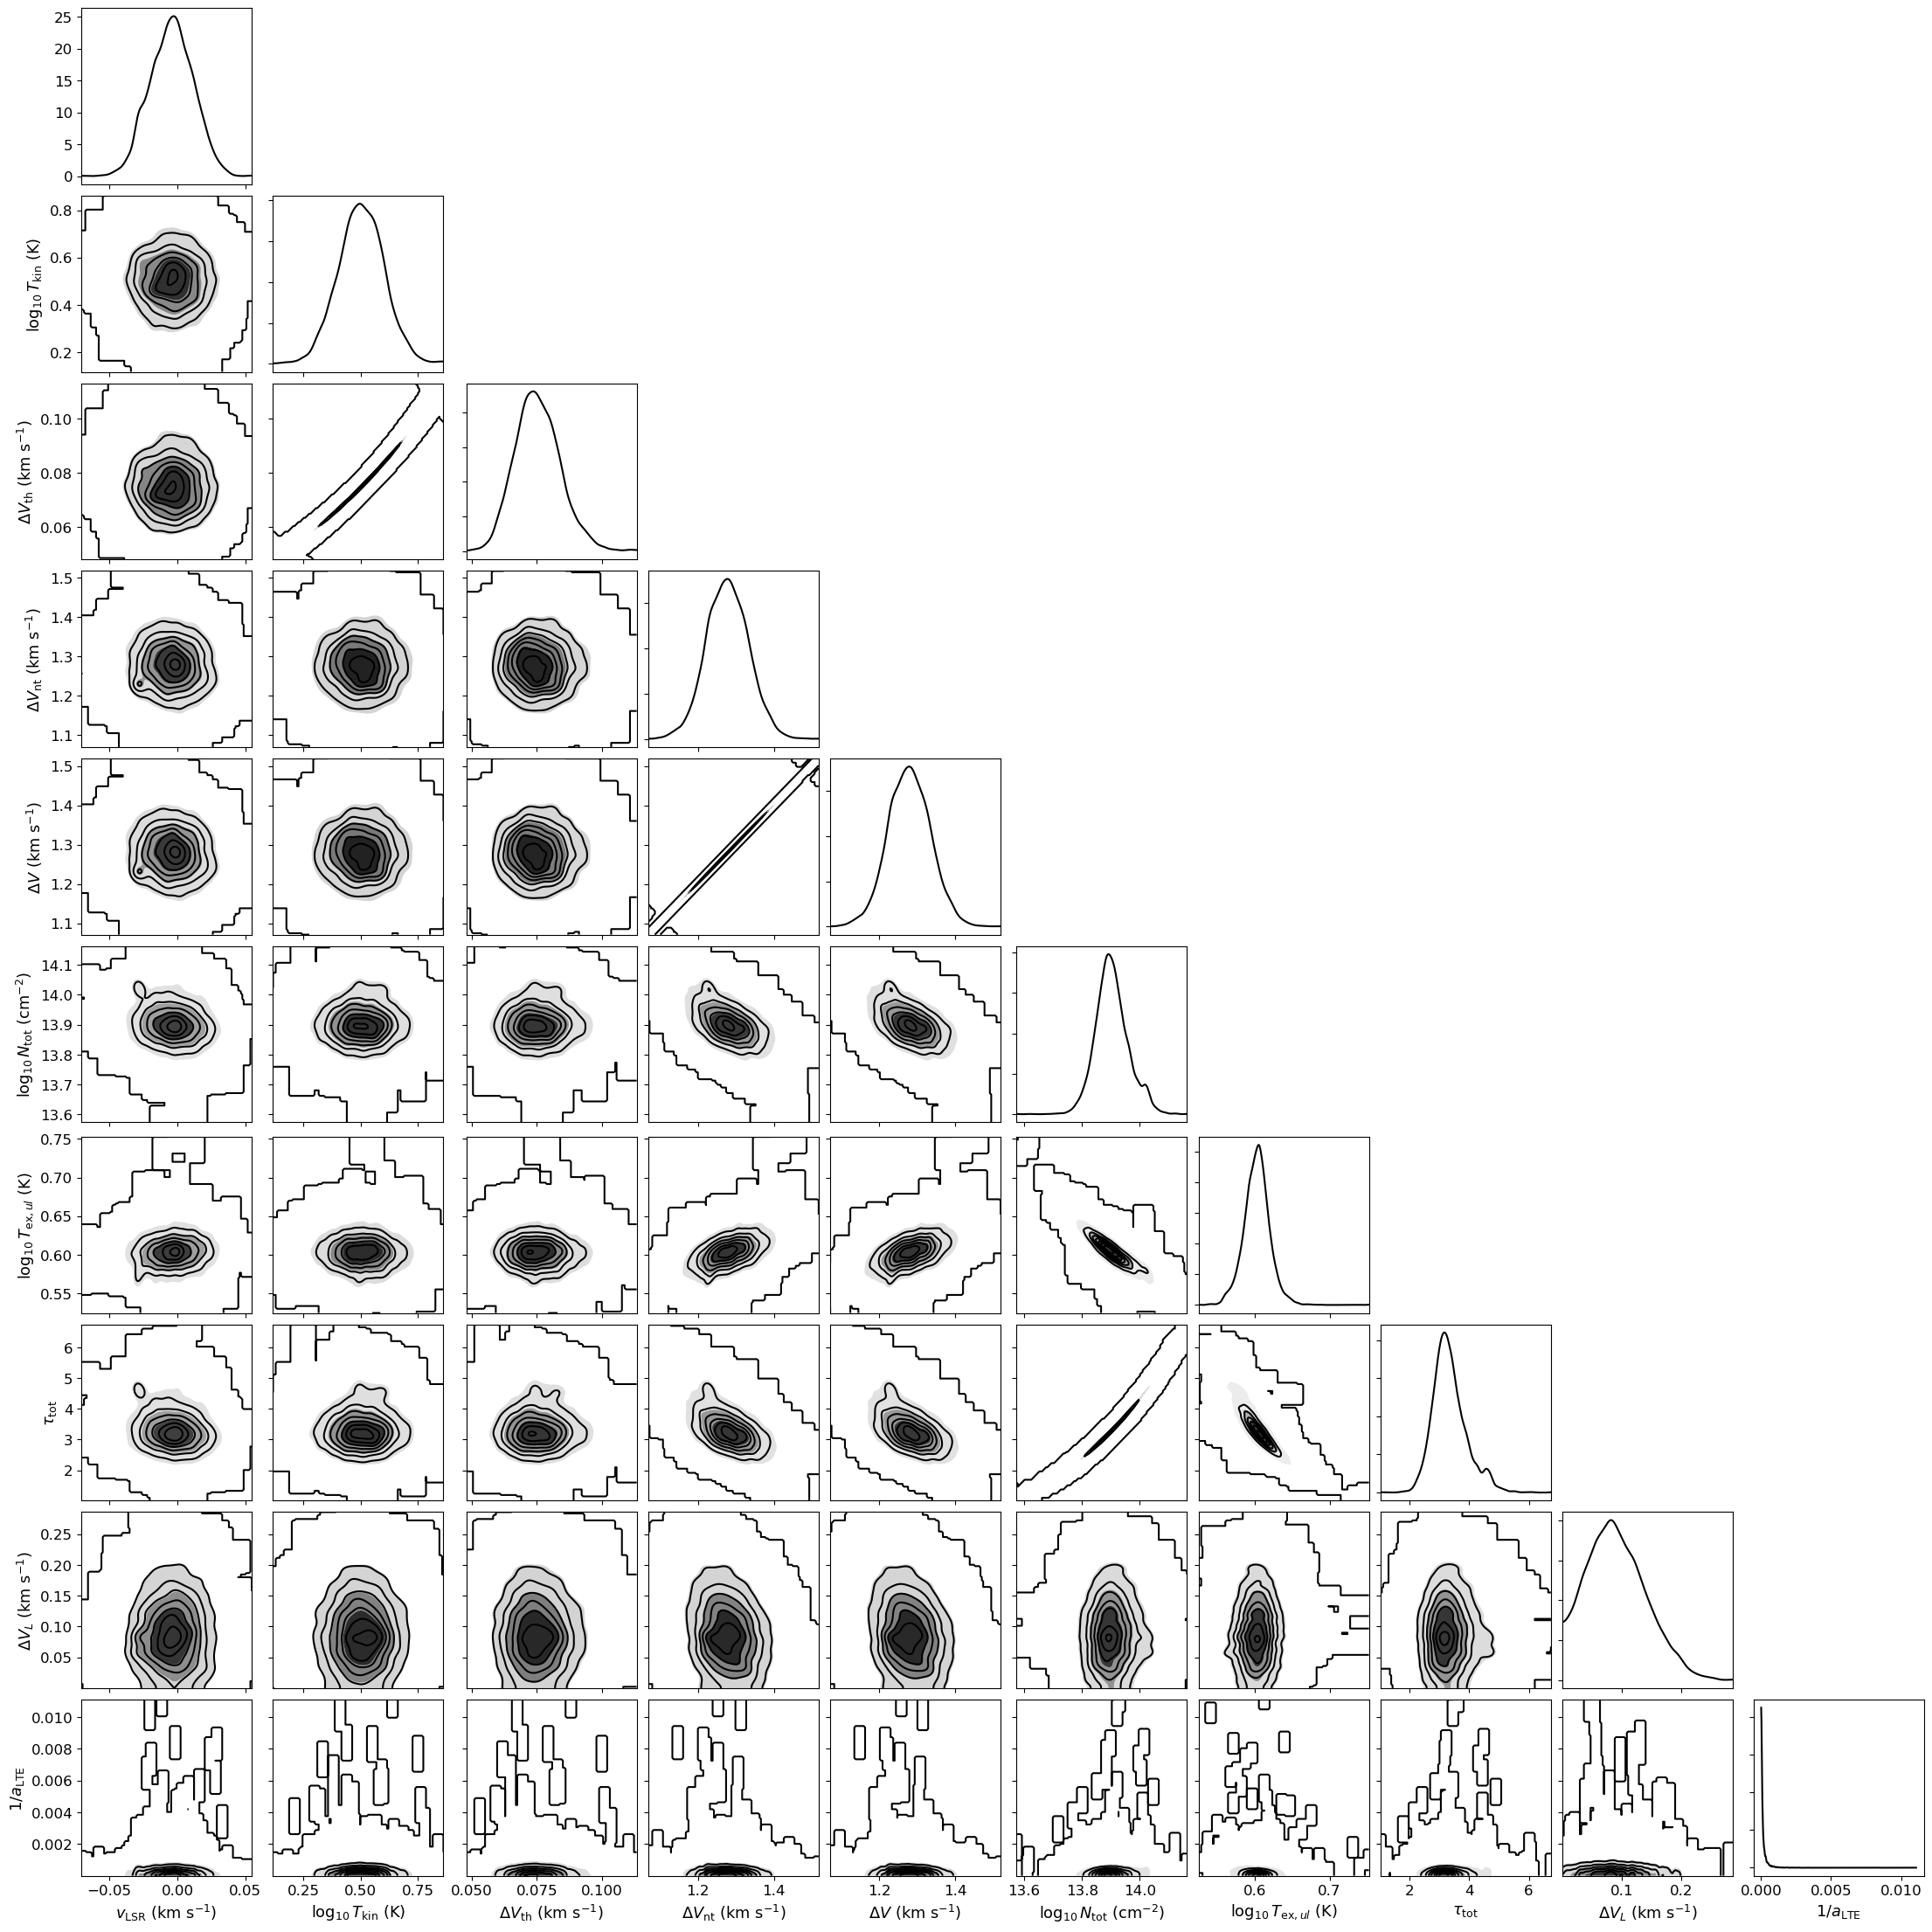

In [40]:
_ = plot_pair(
    model.trace.solution_0.sel(cloud=1), # samples
    var_names + model.hyper_deterministics + ["LTE_precision"], # var_names to plot
    labeller=model.labeller, # label manager
)

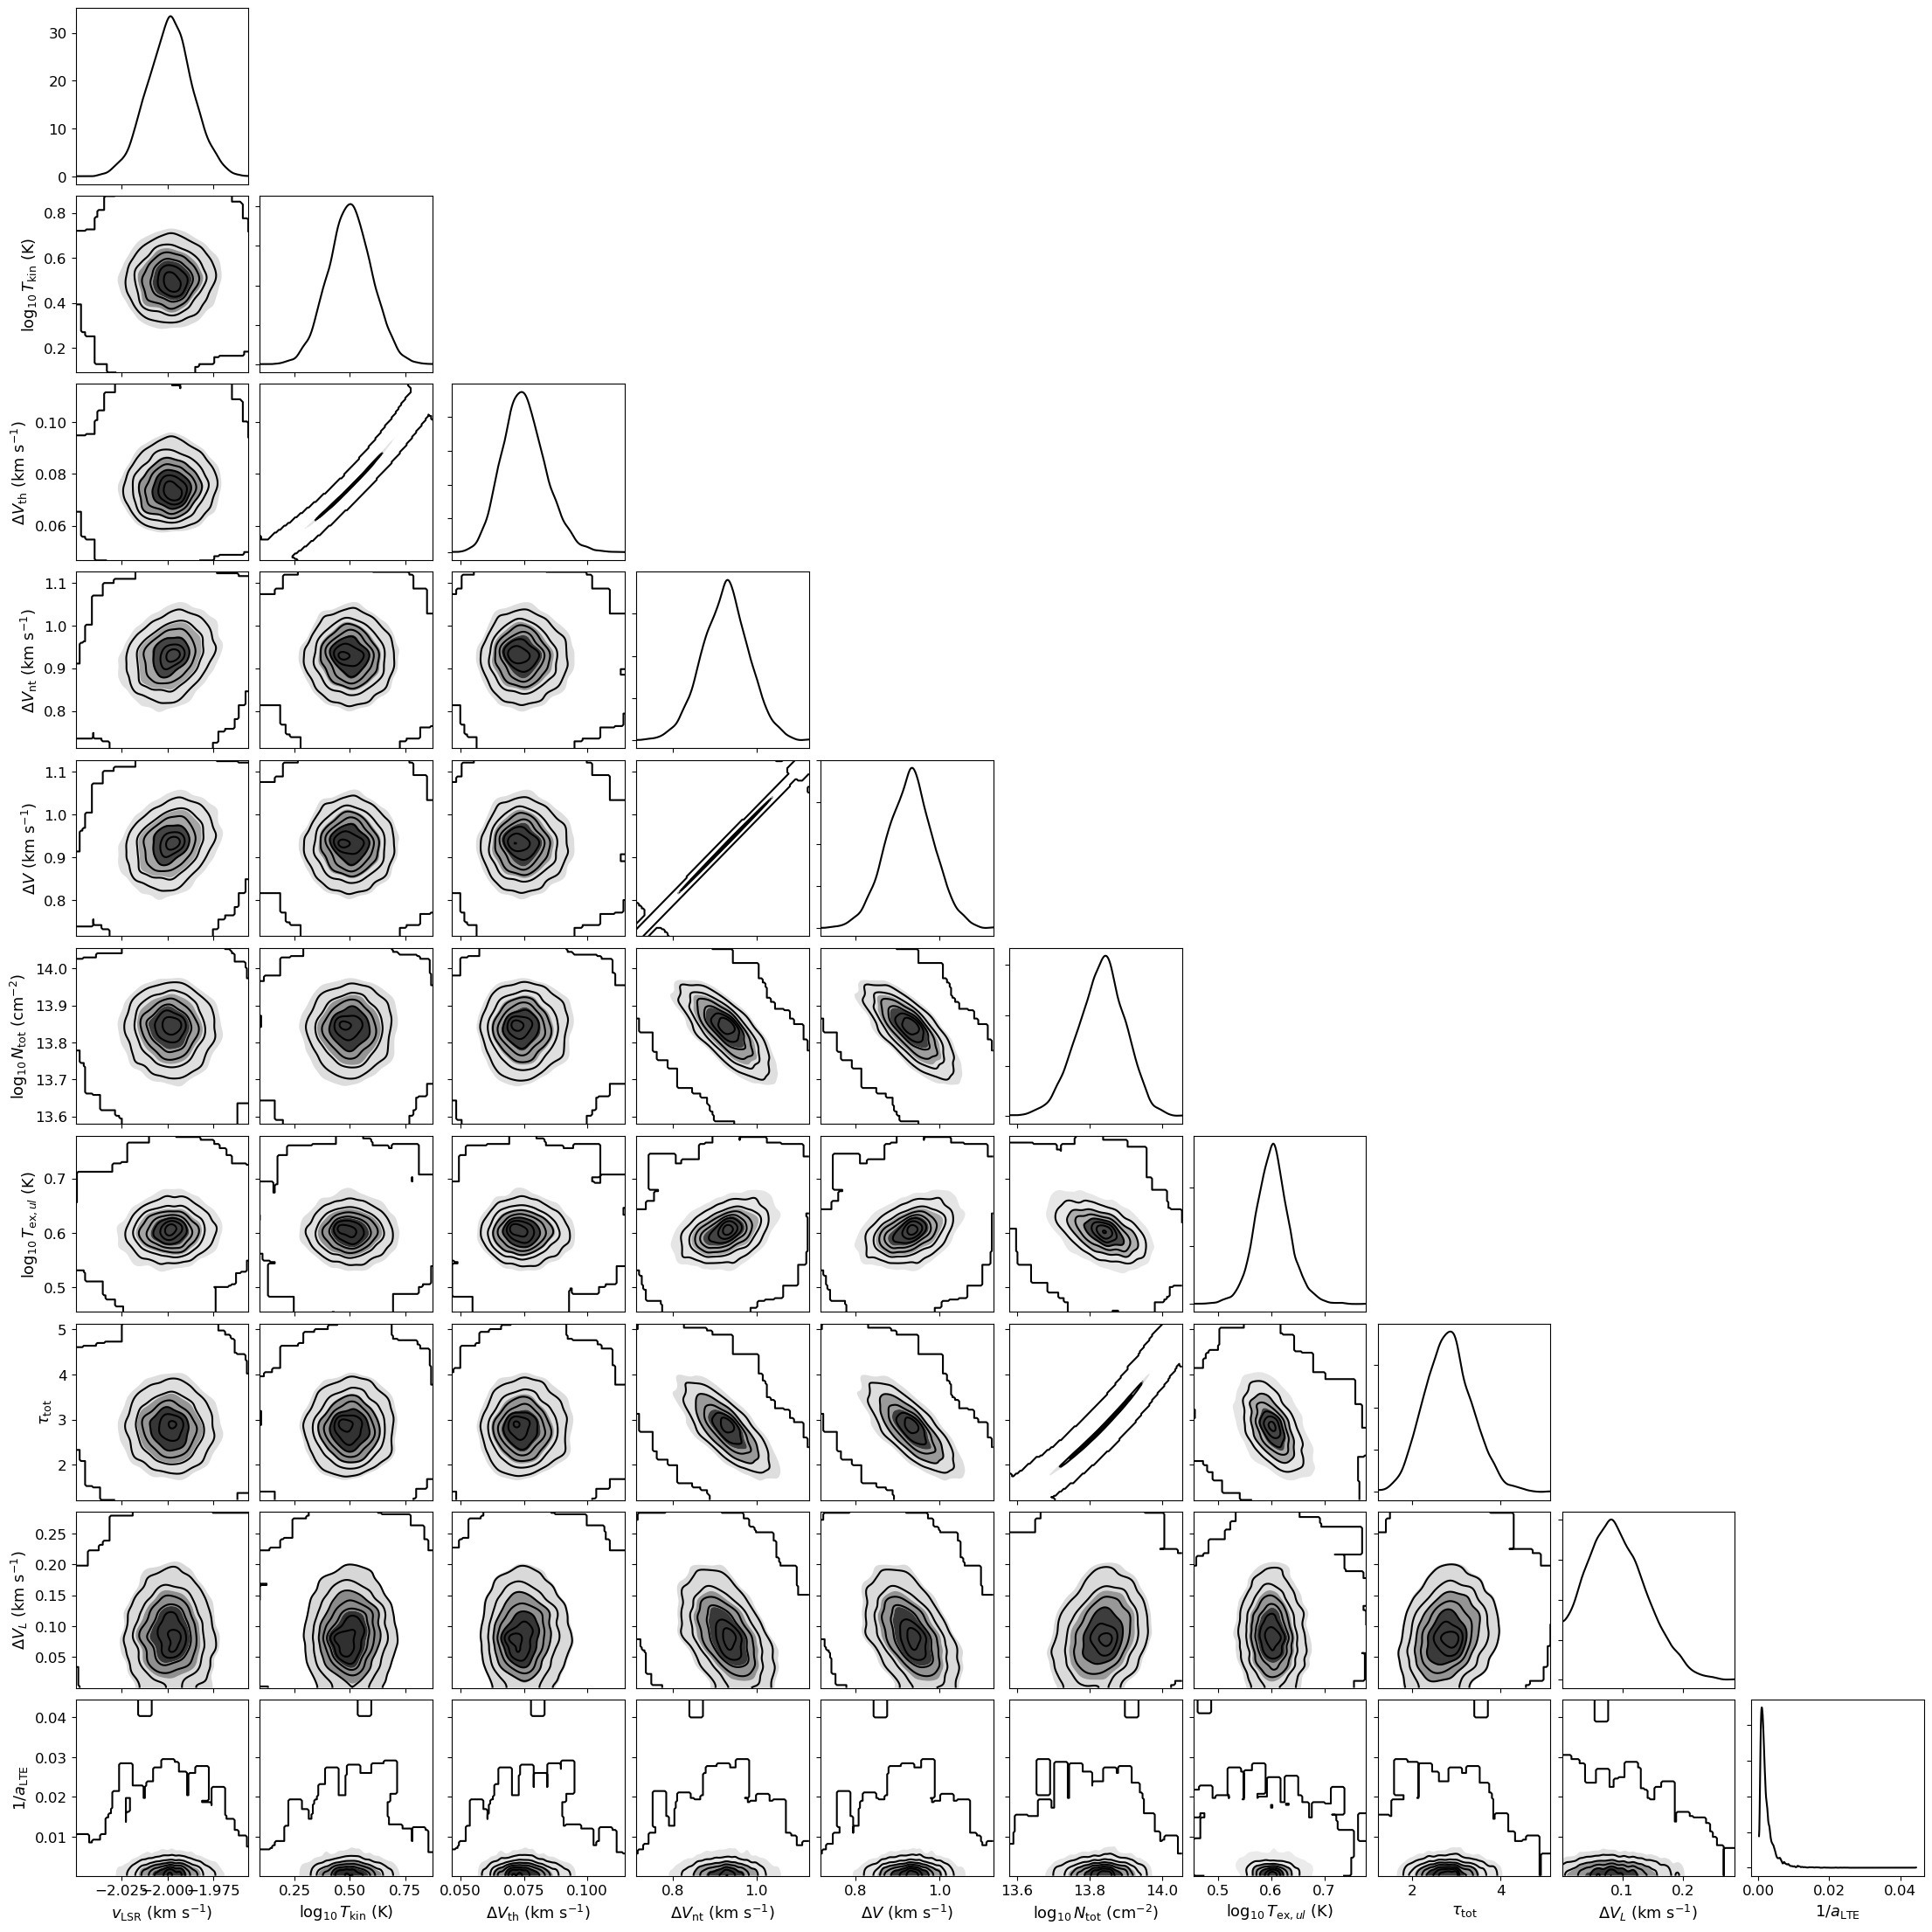

In [41]:
_ = plot_pair(
    model.trace.solution_0.sel(cloud=2), # samples
    var_names + model.hyper_deterministics + ["LTE_precision"], # var_names to plot
    labeller=model.labeller, # label manager
)

In [42]:
var_names=model.cloud_deterministics + model.baseline_freeRVs + model.hyper_deterministics + ["LTE_precision"]
point_stats = az.summary(model.trace.solution_0, var_names=var_names, kind='stats', hdi_prob=0.68)
print("BIC:", model.bic())
display(point_stats)

BIC: -3254.6984747558795


mean     sd  hdi_16%  hdi_84%
velocity[0]               2.504  0.037    2.468    2.541
velocity[1]              -0.004  0.016   -0.019    0.013
velocity[2]              -1.999  0.012   -2.011   -1.986
log10_Tkin[0]             0.502  0.099    0.407    0.599
log10_Tkin[1]             0.503  0.101    0.410    0.604
log10_Tkin[2]             0.500  0.100    0.400    0.596
fwhm_thermal[0]           0.075  0.009    0.066    0.083
fwhm_thermal[1]           0.075  0.009    0.067    0.084
fwhm_thermal[2]           0.075  0.009    0.065    0.082
fwhm_nonthermal[0]        1.556  0.119    1.438    1.668
fwhm_nonthermal[1]        1.277  0.056    1.220    1.327
fwhm_nonthermal[2]        0.926  0.056    0.873    0.983
fwhm[0]                   1.558  0.119    1.441    1.670
fwhm[1]                   1.279  0.056    1.224    1.331
fwhm[2]                   0.929  0.056    0.872    0.982
log10_N[0]               13.856  0.139   13.751   13.994
log10_N[1]               13.904  0.057   13.842   13.948
log10_N[2]               13.833  0.066   13.773   13.905
log10_Tex_ul[0]           0.521  0.025    0.497    0.529
log10_Tex_ul[1]           0.603  0.017    0.586    0.617
log10_Tex_ul[2]           0.602  0.033    0.567    0.628
Tex[113123.3687, 0]       3.306  0.239    3.088    3.383
Tex[113123.3687, 1]       3.997  0.193    3.825    4.175
Tex[113123.3687, 2]       3.892  0.208    3.660    4.029
Tex[113144.19, 0]         3.331  0.243    3.107    3.383
Tex[113144.19, 1]         4.030  0.182    3.865    4.188
Tex[113144.19, 2]         4.350  0.303    4.025    4.543
Tex[113170.535, 0]        3.329  0.238    3.116    3.388
Tex[113170.535, 1]        3.999  0.177    3.826    4.149
Tex[113170.535, 2]        3.568  0.136    3.401    3.644
Tex[113191.325, 0]        3.356  0.246    3.138    3.402
Tex[113191.325, 1]        4.033  0.169    3.869    4.163
Tex[113191.325, 2]        3.948  0.205    3.720    4.075
Tex[113488.142, 0]        3.281  0.210    3.087    3.347
Tex[113488.142, 1]        3.929  0.171    3.762    4.085
Tex[113488.142, 2]        3.611  0.139    3.454    3.703
Tex[113490.985, 0]        3.315  0.147    3.177    3.344
Tex[113490.985, 1]        4.045  0.102    3.942    4.127
Tex[113490.985, 2]        4.460  0.167    4.268    4.546
Tex[113499.643, 0]        3.371  0.266    3.134    3.428
Tex[113499.643, 1]        4.015  0.181    3.840    4.168
Tex[113499.643, 2]        3.794  0.167    3.600    3.903
Tex[113508.934, 0]        3.307  0.219    3.107    3.357
Tex[113508.934, 1]        3.961  0.163    3.806    4.107
Tex[113508.934, 2]        4.000  0.219    3.743    4.127
Tex[113520.4215, 0]       3.399  0.286    3.153    3.446
Tex[113520.4215, 1]       4.050  0.179    3.883    4.196
Tex[113520.4215, 2]       4.228  0.274    3.918    4.398
tau[113123.3687, 0]       0.047  0.016    0.030    0.060
tau[113123.3687, 1]       0.041  0.007    0.033    0.046
tau[113123.3687, 2]       0.038  0.007    0.030    0.044
tau[113144.19, 0]         0.375  0.129    0.252    0.485
tau[113144.19, 1]         0.328  0.057    0.267    0.366
tau[113144.19, 2]         0.257  0.053    0.199    0.304
tau[113170.535, 0]        0.371  0.129    0.244    0.476
tau[113170.535, 1]        0.325  0.058    0.260    0.362
tau[113170.535, 2]        0.316  0.057    0.250    0.362
tau[113191.325, 0]        0.475  0.164    0.313    0.609
tau[113191.325, 1]        0.416  0.072    0.340    0.465
tau[113191.325, 2]        0.340  0.068    0.268    0.402
tau[113488.142, 0]        0.486  0.168    0.318    0.620
tau[113488.142, 1]        0.428  0.076    0.343    0.476
tau[113488.142, 2]        0.409  0.074    0.323    0.470
tau[113490.985, 0]        1.267  0.428    0.877    1.655
tau[113490.985, 1]        1.105  0.182    0.904    1.224
tau[113490.985, 2]        0.854  0.166    0.673    1.002
tau[113499.643, 0]        0.380  0.132    0.248    0.487
tau[113499.643, 1]        0.334  0.060    0.270    0.375
tau[113499.643, 2]        0.316  0.058    0.257    0.371
tau[113508.934, 0]        0.369  0.12

In [43]:
print(sim_params)
print(derived_params)

{'log10_N': [13.8, 13.9, 14.0], 'log10_Tkin': [0.65, 0.6, 0.5], 'fwhm_nonthermal': [1.0, 1.25, 1.5], 'velocity': [-2.0, 0.0, 2.5], 'fwhm_L': 0.0, 'log10_Tex_ul': [0.65, 0.6, 0.5], 'LTE_precision': [0.001, 0.0001, 1e-05], 'baseline_12CN-1_norm': [0.0], 'baseline_12CN-2_norm': [0.0]}
{'Tex': array([[4.12856026, 3.96747503, 3.1873019 ],
       [4.5399173 , 4.04696193, 3.20464574],
       [3.69857846, 3.9586397 , 3.15530444],
       [4.0252573 , 4.03773639, 3.17229877],
       [3.71034399, 3.88448667, 3.11707554],
       [4.45664982, 4.00846584, 3.18036483],
       [3.84982054, 3.95676735, 3.16007077],
       [4.03819297, 3.96041608, 3.13361988],
       [4.20388635, 4.03555478, 3.17706572]]), 'tau': array([[0.03279808, 0.04037087, 0.06329175],
       [0.22725104, 0.31871474, 0.51230958],
       [0.27585192, 0.3230911 , 0.50791146],
       [0.30592721, 0.4046493 , 0.65221735],
       [0.35900344, 0.42479004, 0.66481766],
       [0.77590433, 1.08261416, 1.73688715],
       [0.2786214 , 0.332